# Fire radiative power and active fire pixels from 2020 to present derived from satellite observations
This dataset provides active fire (AF) and fire radiative power (FRP) products derived from observations made by the Sea and Land Surface Temperature Radiometer (SLSTR) operating concurrently onboard the European Sentinel-3A and -3B satellites. These products are generated from the non-time critical (NTC) Level 2 AF detection and FRP product from European Space Agency (ESA). The AF, FRP and the Burnt Areas are Essential Climate Variables (ECV) from the Global Observing System for Climate (GCOS). Burnt Area is provided through a different catalogue entry.

In [111]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy as sp
import functools

In [113]:
from platform import python_version
import sys
print('Python: ' + python_version()) # Python: 3.12.2
print('pandas: ' + pd.__version__) # pandas: 2.2.1
print('numpy: ' + np.__version__) # numpy: 1.26.4
print ('matplotlib: ' + sys.modules["matplotlib"].__version__) # matplotlib: 3.8.3
print('seaborn: ' + sns.__version__) # seaborn: 0.13.2
print('scipy: ' + sp.__version__) # scipy: 1.12.0

Python: 3.12.2
pandas: 2.2.1
numpy: 1.26.4
matplotlib: 3.8.3
seaborn: 0.13.2
scipy: 1.12.0


# First look into the Dataset

In [3]:
Datasetpath = "datasets_daily/dataset-satellite-fire-radiative-power_combined/"

In [4]:
# all Files in the dataset
dataset_list = os.listdir(Datasetpath)
dataset_list

['20200301-C3S-L2-FRP-SLSTR-P1M-fv1.0.csv',
 '20200401-C3S-L2-FRP-SLSTR-P1M-fv1.0.csv',
 '20200501-C3S-L2-FRP-SLSTR-P1M-fv1.0.csv',
 '20200601-C3S-L2-FRP-SLSTR-P1M-fv1.0.csv',
 '20200701-C3S-L2-FRP-SLSTR-P1M-fv1.0.csv',
 '20200801-C3S-L2-FRP-SLSTR-P1M-fv1.0.csv',
 '20200901-C3S-L2-FRP-SLSTR-P1M-fv1.0.csv',
 '20201001-C3S-L2-FRP-SLSTR-P1M-fv1.0.csv',
 '20201101-C3S-L2-FRP-SLSTR-P1M-fv1.0.csv',
 '20201201-C3S-L2-FRP-SLSTR-P1M-fv1.0.csv',
 '20210101-C3S-L2-FRP-SLSTR-P1M-fv1.0.csv',
 '20210201-C3S-L2-FRP-SLSTR-P1M-fv1.0.csv']

In [5]:
temp = pd.read_csv(Datasetpath+"20200301-C3S-L2-FRP-SLSTR-P1M-fv1.0.csv", sep = '\t')

In [6]:
# File header
temp[:5]

,Column,Row,Date,Time,Latitude,Longitude,sat_zenith,FRP_MWIR,FRP_MWIR_uncertainty,FRP_SWIR,FRP_SWIR_uncertainty,Confidence,F1_flag,Day_flag,Area,Platform,Land/Ocean,Hotspot_class
0,1102,954,20200301,10813,-20.04511,-44.91568,10.10405,2.908418,0.621121,0.000000,-1.000000,0.0,0,0,1179637.125,S3B,1,1
1,459,1071,20200301,10854,-17.65403,-39.24297,38.03109,4.561074,0.715353,0.000000,-1.000000,0.0,0,0,2207239.750,S3B,1,1
2,512,31,20200301,10914,-16.36876,-40.09173,34.87470,6.209808,2.571126,0.000000,-1.000000,0.0,0,0,1976518.125,S3B,1,1
3,511,29,20200301,10914,-16.37848,-40.08594,34.93529,5.360111,2.006838,35.406391,8.067273,1.0,0,0,1976518.125,S3B,1,1
4,510,31,20200301,10914,-16.36404,-40.07747,34.99621,5.476526,0.996112,18.785072,4.249864,1.0,0,0,1981577.625,S3B,1,1


In [7]:
temp.shape

(208912, 18)

All data files have the same columns

### Information held within each Level 2 Monthly Global Fire Location & FRP Summary File at the location of each detected active fire (AF) pixel.
|Name|Units|Comment|
|---:|:-------|:-----------|
|Column|Pixel|Across-track image grid index for the detected AF pixel|
|Row| Pixel| Along-track image grid index for the detected AF pixel
|Date|| Date in the format of YYYYMMDD
|Time|| Time in the format of HHMMSS
|Latitude| degrees| Latitude
|Longitude| degrees| Longitude
|sat_zenith| degrees| Satellite (view) zenith angle
|FRP_MWIR| MW| Fire radiative power computed from the middle infrared (mid-wave infrared) channel observation (either S7 or F1; both located in the MIR atmospheric window)
|FRP_MWIR_uncertainty| MW| Uncertainty of Fire radiative power computed from the MIR channel observation (either S7 or F1)
|FRP_SWIR| MW| Fire radiative power computed from the SWIR channel observation (S6)
|FRP_SWIR_uncertainty| MW| Uncertainty of Fire radiative power computed from the SWIR channel observation (S6)
|Confidence| |Fire detection confidence
|F1_flag|| Boolean flag indicating the data from which channel was used in the FRP calculation, with 0 referring to S7 and 1 to F1
|Day_flag|| Boolean flag indicating a daytime or nighttime AF detection
|Area| m2| Projected area of the pixel footprint on the Earth surface
|Platform|| Sentinel-3A or Sentinel -3B
|Land/Ocean|| Landcover information with land as 1 and ocean as 0
|Hotspot_class|| Classification of fires, with different number indicate different class as following: 0 as vegetation fire; 1 as onshore gas flare; 2 as offshore gas flare; 3 as volcanic and 4 as industrial fires

# Import and combine all Fire RP and AFP data

In [8]:
dataset_comb = pd.DataFrame()
for dataset in dataset_list:
    temp = pd.read_csv(Datasetpath+dataset, sep = '\t')
    # ignore_index to keep the rownames continues
    dataset_comb = pd.concat([dataset_comb, temp], ignore_index = True)

In [9]:
dataset_comb = dataset_comb.astype({"F1_flag": bool, "Day_flag":bool, "Land/Ocean": bool})

In [10]:
dataset_comb[:5]

,Column,Row,Date,Time,Latitude,Longitude,sat_zenith,FRP_MWIR,FRP_MWIR_uncertainty,FRP_SWIR,FRP_SWIR_uncertainty,Confidence,F1_flag,Day_flag,Area,Platform,Land/Ocean,Hotspot_class
0,1102,954,20200301,10813,-20.04511,-44.91568,10.10405,2.908418,0.621121,0.000000,-1.000000,0.0,False,False,1179637.125,S3B,True,1
1,459,1071,20200301,10854,-17.65403,-39.24297,38.03109,4.561074,0.715353,0.000000,-1.000000,0.0,False,False,2207239.750,S3B,True,1
2,512,31,20200301,10914,-16.36876,-40.09173,34.87470,6.209808,2.571126,0.000000,-1.000000,0.0,False,False,1976518.125,S3B,True,1
3,511,29,20200301,10914,-16.37848,-40.08594,34.93529,5.360111,2.006838,35.406391,8.067273,1.0,False,False,1976518.125,S3B,True,1
4,510,31,20200301,10914,-16.36404,-40.07747,34.99621,5.476526,0.996112,18.785072,4.249864,1.0,False,False,1981577.625,S3B,True,1


In [11]:
dataset_comb.shape

(4811629, 18)

In [12]:
dataset_comb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4811629 entries, 0 to 4811628
Data columns (total 18 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Column                int64  
 1   Row                   int64  
 2   Date                  int64  
 3   Time                  int64  
 4   Latitude              float64
 5   Longitude             float64
 6   sat_zenith            float64
 7   FRP_MWIR              float64
 8   FRP_MWIR_uncertainty  float64
 9   FRP_SWIR              float64
 10  FRP_SWIR_uncertainty  float64
 11  Confidence            float64
 12  F1_flag               bool   
 13  Day_flag              bool   
 14  Area                  float64
 15  Platform              object 
 16  Land/Ocean            bool   
 17  Hotspot_class         int64  
dtypes: bool(3), float64(9), int64(5), object(1)
memory usage: 564.4+ MB


### Check for null values

In [13]:
dataset_comb.isnull().apply(sum)

Column                    0
Row                       0
Date                      0
Time                      0
Latitude                  0
Longitude                 0
sat_zenith                0
FRP_MWIR                  0
FRP_MWIR_uncertainty    201
FRP_SWIR                  8
FRP_SWIR_uncertainty      0
Confidence                3
F1_flag                   0
Day_flag                  0
Area                      0
Platform                  0
Land/Ocean                0
Hotspot_class             0
dtype: int64

In [14]:
dataset_comb.loc[np.isnan(dataset_comb.loc[:,"FRP_SWIR"]),:]

,Column,Row,Date,Time,Latitude,Longitude,sat_zenith,FRP_MWIR,FRP_MWIR_uncertainty,FRP_SWIR,FRP_SWIR_uncertainty,Confidence,F1_flag,Day_flag,Area,Platform,Land/Ocean,Hotspot_class
239304,572,349,20200404,182932,25.15950,52.87001,31.28697,13.460341,NaN,NaN,20.247503,0.0,False,False,1763363.625,S3B,True,1
508061,848,407,20200513,181819,25.16554,52.87855,12.92536,14.696589,NaN,NaN,2.607157,1.0,True,False,1219997.375,S3B,True,1
534791,479,331,20200524,183327,25.16284,52.87861,37.01294,11.190263,NaN,NaN,20.657728,1.0,False,False,2128436.500,S3B,True,1
613428,341,837,20200612,202627,40.42474,24.00155,44.71772,59.221592,NaN,NaN,38.527187,1.0,True,False,2927804.750,S3B,True,1
687317,572,348,20200624,182942,25.16627,52.87537,31.27198,23.665148,NaN,NaN,9.554665,1.0,True,False,1763363.625,S3B,True,1
753365,497,386,20200702,200024,15.00830,32.39913,35.95391,61.312607,NaN,NaN,6.729961,1.0,True,False,2049604.000,S3B,True,1
789284,849,407,20200706,181824,25.16090,52.87307,12.85721,8.778890,NaN,NaN,6.660689,1.0,True,False,909662.000,S3B,True,1
970588,665,368,20200725,182555,25.16125,52.87016,25.22068,6.860586,NaN,NaN,9.840313,1.0,False,False,1502607.500,S3B,True,1


The NaN values in the .csv file is noted as `NaN`

### Statistical description of the data in the combined dataset

In [15]:
dataset_comb.describe()

C:\Users\yinsh\AppData\Roaming\Python\Python312\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,Column,Row,Date,Time,Latitude,Longitude,sat_zenith,FRP_MWIR,FRP_MWIR_uncertainty,FRP_SWIR,FRP_SWIR_uncertainty,Confidence,Area,Hotspot_class
count,4.811629e+06,4.811629e+06,4.811629e+06,4.811629e+06,4.811629e+06,4.811629e+06,4.811629e+06,4.811629e+06,4.811428e+06,4811621.0,4.811629e+06,4.811626e+06,4.811629e+06,4.811629e+06
mean,9.121595e+02,6.098424e+02,2.020247e+07,1.303753e+05,1.228936e+01,2.271474e+01,2.174786e+01,6.429733e+00,5.787656e+07,inf,-7.794210e-02,1.659542e-01,1.127717e+06,1.024514e+00
std,3.383390e+02,3.557722e+02,3.543037e+03,7.425476e+04,2.752016e+01,7.264889e+01,1.245771e+01,2.388893e+01,4.668837e+10,NaN,8.449844e+00,3.499269e-01,4.972487e+05,3.706593e-01
min,2.700000e+01,0.000000e+00,2.020030e+07,5.700000e+01,-5.367401e+01,-1.799416e+02,6.165670e+00,2.230000e-04,2.300000e-05,0.0,-1.000000e+00,0.000000e+00,8.783827e+05,1.000000e+00
25%,6.730000e+02,2.970000e+02,2.020080e+07,4.180400e+04,-1.129612e+01,-4.951886e+01,1.103582e+01,1.529017e+00,5.772980e-01,0.0,-1.000000e+00,0.000000e+00,9.029531e+05,1.000000e+00
50%,9.430000e+02,6.150000e+02,2.020092e+07,1.514290e+05,9.278150e+00,2.908652e+01,1.962835e+01,2.842388e+00,1.177903e+00,0.0,-1.000000e+00,0.000000e+00,9.903868e+05,1.000000e+00
75%,1.184000e+03,9.290000e+02,2.020113e+07,1.951580e+05,3.178035e+01,7.781632e+01,2.977095e+01,5.542453e+00,2.919907e+00,0.0,-1.000000e+00,0.000000e+00,1.160107e+06,1.000000e+00
max,1.489000e+03,1.202000e+03,2.021023e+07,2.357350e+05,7.952248e+01,1.799711e+02,5.886998e+01,2.272188e+03,6.916426e+13,inf,1.066913e+03,1.000000e+00,6.341762e+06,8.000000e+00


In [16]:
dataset_comb.describe(include=["object", "bool"])

,F1_flag,Day_flag,Platform,Land/Ocean
count,4811629,4811629,4811629,4811629
unique,2,1,2,1
top,True,False,S3B,True
freq,4144742,4811629,2510521,4811629


### Check for Inf values in the FRP_SWIR column

In [17]:
dataset_comb.loc[dataset_comb.loc[:,"FRP_SWIR"] == np.inf,:]

,Column,Row,Date,Time,Latitude,Longitude,sat_zenith,FRP_MWIR,FRP_MWIR_uncertainty,FRP_SWIR,FRP_SWIR_uncertainty,Confidence,F1_flag,Day_flag,Area,Platform,Land/Ocean,Hotspot_class
74,1208,99,20200301,15339,0.46114,-60.31379,16.93200,3.037738,0.429035,inf,6.759590,1.0,True,False,1277892.750,S3A,True,1
17601,698,100,20200303,203640,12.09694,21.78077,23.01587,1.396257,0.207152,inf,6.774741,1.0,True,False,1000303.125,S3B,True,1
373539,1048,561,20200419,32911,15.51574,-85.17283,7.42810,3.274413,0.751482,inf,3.713371,1.0,False,False,1158533.000,S3B,True,1
444965,1107,872,20200429,22709,7.52391,-68.91912,10.43622,3.139317,0.526311,inf,5.480433,1.0,False,False,1182452.625,S3B,True,1
508409,1095,32,20200513,182022,31.93035,48.49031,9.71827,6.154272,0.835566,inf,3.768298,1.0,False,False,1175910.875,S3B,True,1
799266,503,969,20200707,210456,-8.08402,19.66082,35.50563,6.377586,0.872699,inf,6.066683,1.0,False,False,2022848.375,S3B,True,1


The inf values in the .csv file is noted as `Infinity`

In [18]:
temp = dataset_comb.loc[~ (dataset_comb.loc[:,"FRP_SWIR"] == np.inf),:]
temp.describe()

,Column,Row,Date,Time,Latitude,Longitude,sat_zenith,FRP_MWIR,FRP_MWIR_uncertainty,FRP_SWIR,FRP_SWIR_uncertainty,Confidence,Area,Hotspot_class
count,4.811623e+06,4.811623e+06,4.811623e+06,4.811623e+06,4.811623e+06,4.811623e+06,4.811623e+06,4.811623e+06,4.811422e+06,4.811615e+06,4.811623e+06,4.811620e+06,4.811623e+06,4.811623e+06
mean,9.121595e+02,6.098426e+02,2.020247e+07,1.303753e+05,1.228937e+01,2.271479e+01,2.174786e+01,6.429737e+00,5.787663e+07,1.996071e+11,-7.794896e-02,1.659532e-01,1.127717e+06,1.024514e+00
std,3.383391e+02,3.557721e+02,3.543039e+03,7.425473e+04,2.752017e+01,7.264889e+01,1.245771e+01,2.388895e+01,4.668840e+10,2.232141e+14,8.449847e+00,3.499259e-01,4.972488e+05,3.706595e-01
min,2.700000e+01,0.000000e+00,2.020030e+07,5.700000e+01,-5.367401e+01,-1.799416e+02,6.165670e+00,2.230000e-04,2.300000e-05,0.000000e+00,-1.000000e+00,0.000000e+00,8.783827e+05,1.000000e+00
25%,6.730000e+02,2.970000e+02,2.020080e+07,4.180400e+04,-1.129612e+01,-4.951868e+01,1.103584e+01,1.529017e+00,5.772980e-01,0.000000e+00,-1.000000e+00,0.000000e+00,9.029531e+05,1.000000e+00
50%,9.430000e+02,6.150000e+02,2.020092e+07,1.514290e+05,9.278150e+00,2.908655e+01,1.962835e+01,2.842387e+00,1.177904e+00,0.000000e+00,-1.000000e+00,0.000000e+00,9.903868e+05,1.000000e+00
75%,1.184000e+03,9.290000e+02,2.020113e+07,1.951580e+05,3.178035e+01,7.781637e+01,2.977095e+01,5.542451e+00,2.919914e+00,0.000000e+00,-1.000000e+00,0.000000e+00,1.160107e+06,1.000000e+00
max,1.489000e+03,1.202000e+03,2.021023e+07,2.357350e+05,7.952248e+01,1.799711e+02,5.886998e+01,2.272188e+03,6.916426e+13,3.511426e+17,1.066913e+03,1.000000e+00,6.341762e+06,8.000000e+00


## Check if all Dates are in ascending order

In [19]:
functools.reduce(lambda x ,y: [x[0],y] if x[1] <= y else [False,y] ,dataset_comb.loc[:,"Date"], (True, -1))[0]

True

# Look into the Fire radiative power data FRP_MWIR and FRP_SWIR

## Distribution of Fire radiative power FRP_MWIR (mid-wave infrared)

In [20]:
def simple_plot(temp, bins = 50):
    fig, axs = plt.subplots(ncols=3, figsize=(10,5), gridspec_kw={'width_ratios': [1, 1, 3]})
    fig.tight_layout()
    sns.histplot(temp, bins = bins, ax=axs[0])
    sns.boxplot(temp, ax=axs[1])
    sns.lineplot(temp, ax=axs[2])
    plt.show()
    

In [21]:
temp = dataset_comb.loc[:,"FRP_MWIR"]

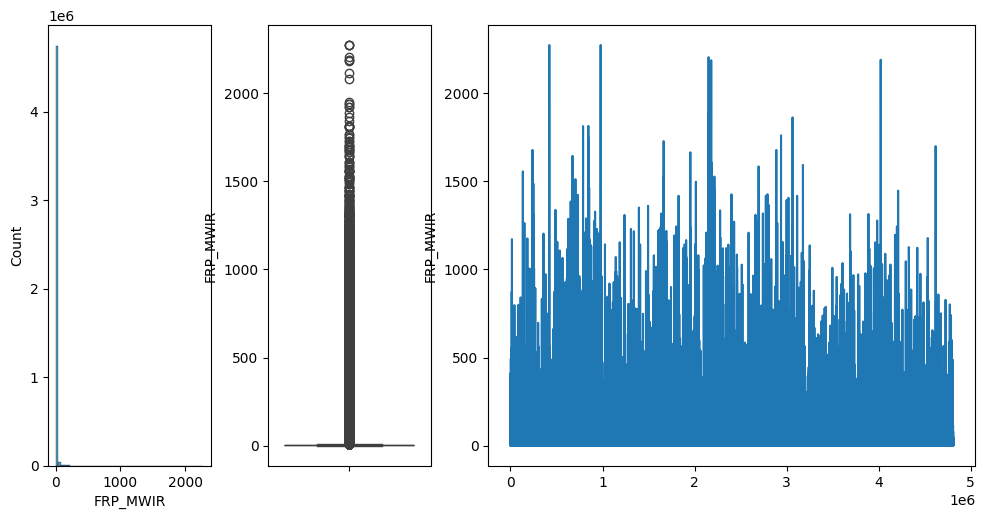

In [22]:
simple_plot(temp)

### Log transfomation of the data

In [23]:
temp = temp.map(math.log)

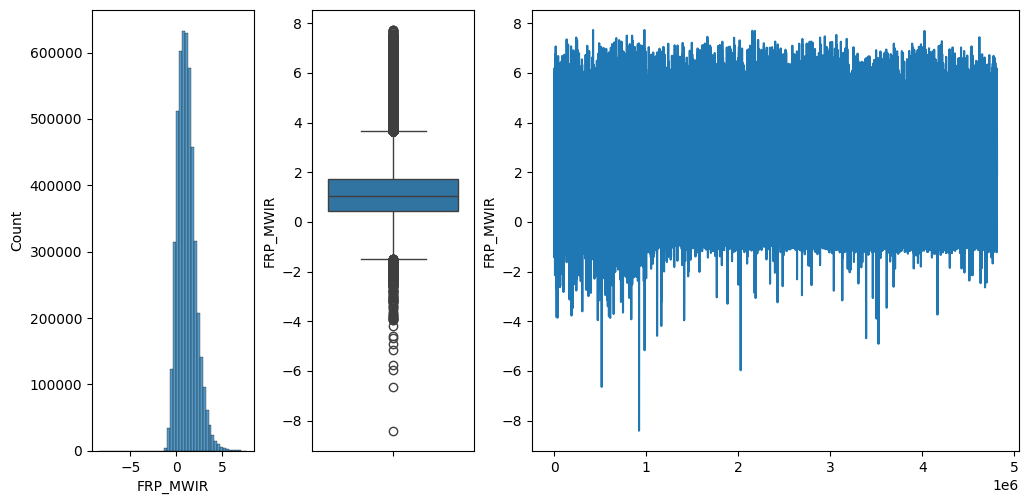

In [24]:
simple_plot(temp)

## Distribution of Fire radiative power FRP_SWIR  (short-wave infrared)

In [25]:
temp = dataset_comb.loc[:,"FRP_SWIR"]

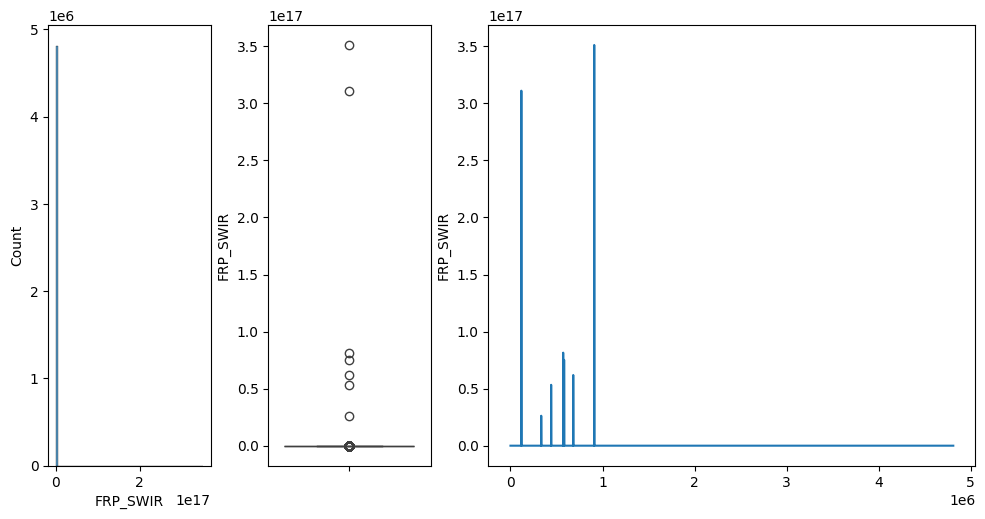

In [26]:
simple_plot(temp)

### Log transfomation of the data

In [27]:
sum(temp == 0)/len(temp)

0.9365206669092734

The more than 90% of the FRP_MWIR column are 0

In [28]:
temp = temp[temp != 0]

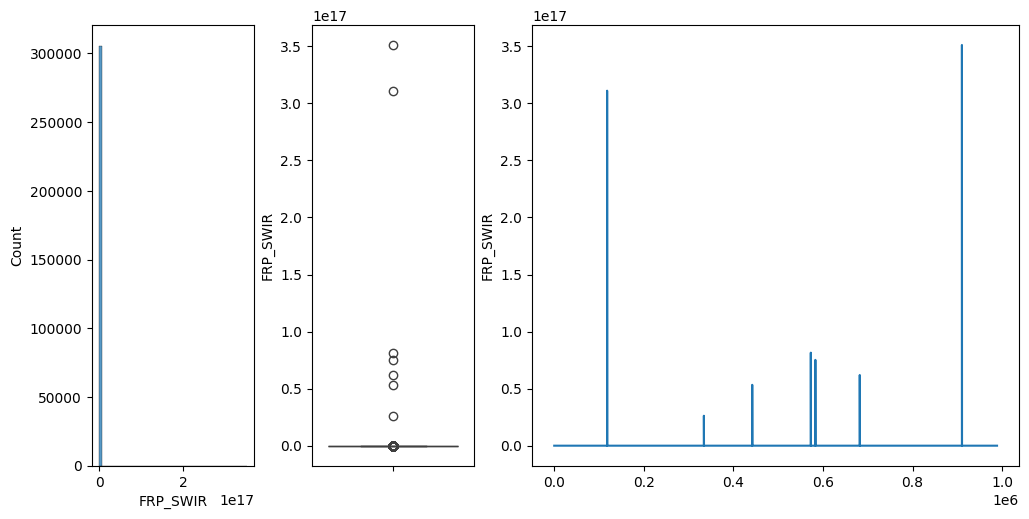

In [29]:
simple_plot(temp)

In [30]:
temp = temp.map(math.log)

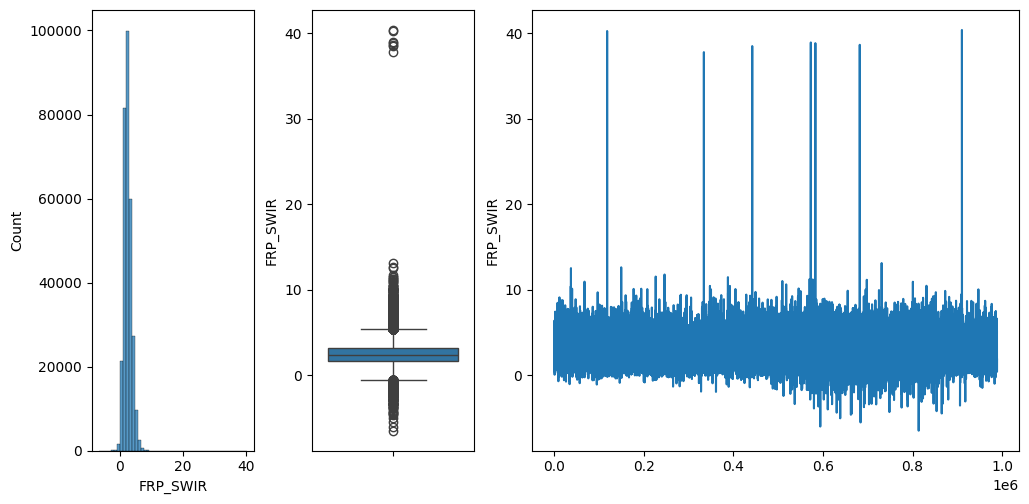

In [31]:
simple_plot(temp)

### Outliers

In [32]:
dataset_comb.loc[dataset_comb.loc[:,"FRP_SWIR"] > 1e13,:]

,Column,Row,Date,Time,Latitude,Longitude,sat_zenith,FRP_MWIR,FRP_MWIR_uncertainty,FRP_SWIR,FRP_SWIR_uncertainty,Confidence,F1_flag,Day_flag,Area,Platform,Land/Ocean,Hotspot_class
74,1208,99,20200301,15339,0.46114,-60.31379,16.93200,3.037738,0.429035,inf,6.759590,1.0,True,False,1277892.750,S3A,True,1
17601,698,100,20200303,203640,12.09694,21.78077,23.01587,1.396257,0.207152,inf,6.774741,1.0,True,False,1000303.125,S3B,True,1
118135,732,159,20200319,152153,23.17617,98.46272,20.71260,6.049931,0.789319,3.110747e+17,9.835240,1.0,False,False,1369673.000,S3B,True,1
334121,1059,236,20200415,124537,44.31132,129.41235,7.72249,1.996513,0.226481,2.623139e+16,4.265402,1.0,True,False,1163129.375,S3A,True,1
373539,1048,561,20200419,32911,15.51574,-85.17283,7.42810,3.274413,0.751482,inf,3.713371,1.0,False,False,1158533.000,S3B,True,1
442071,485,901,20200428,153215,51.29971,93.74672,36.50386,7.414164,1.520722,5.333075e+16,4.311315,1.0,False,False,2055044.625,S3A,True,1
444965,1107,872,20200429,22709,7.52391,-68.91912,10.43622,3.139317,0.526311,inf,5.480433,1.0,False,False,1182452.625,S3B,True,1
508409,1095,32,20200513,182022,31.93035,48.49031,9.71827,6.154272,0.835566,inf,3.768298,1.0,False,False,1175910.875,S3B,True,1
572826,710,890,20200603,174046,50.78696,58.38283,22.09011,6.969927,0.710445,8.151153e+16,8.718936,1.0,False,False,1406398.750,S3B,True,1
583013,517,276,20200605,202834,-24.75241,31.83862,34.50258,10.076201,1.042764,7.519725e+16,4.326418,1.0,False,False,1918076.000,S3A,True,1


In [33]:
temp = temp[temp < 20]

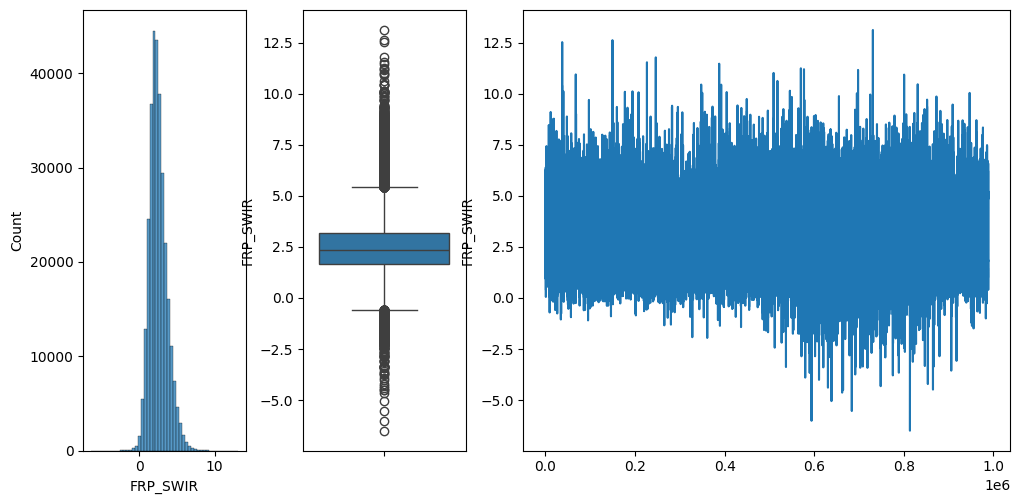

In [34]:
simple_plot(temp)

Note: It seems that the data gathering of the FRP_SWIR are stopped at a certain time point

In [35]:
temp = dataset_comb.loc[:,"FRP_SWIR"]
temp_idx = len(temp) - (temp == 0).iloc[::-1].argmin() -1
temp_idx

988588

988588 is the last entry in FRP_SWIR that is not 0

In [36]:
temp[temp_idx-5:temp_idx+5]

988583     0.000000
988584     0.000000
988585    16.446775
988586     0.000000
988587     0.000000
988588     6.188676
988589     0.000000
988590     0.000000
988591     0.000000
988592     0.000000
Name: FRP_SWIR, dtype: float64

In [37]:
dataset_comb.iloc[temp_idx-5:temp_idx+5,:]

,Column,Row,Date,Time,Latitude,Longitude,sat_zenith,FRP_MWIR,FRP_MWIR_uncertainty,FRP_SWIR,FRP_SWIR_uncertainty,Confidence,F1_flag,Day_flag,Area,Platform,Land/Ocean,Hotspot_class
988583,1386,336,20200727,25306,-15.42989,-74.40662,28.80862,4.150867,0.513345,0.000000,-1.000000,0.0,False,False,1623262.500,S3A,True,1
988584,1068,474,20200727,25314,-13.60182,-71.79250,8.16395,2.652726,0.474880,0.000000,-1.000000,0.0,False,False,1166438.250,S3A,True,1
988585,221,429,20200727,25357,-12.21873,-64.10693,50.77967,7.705409,1.452507,16.446775,3.614730,1.0,False,False,3863871.000,S3A,True,1
988586,1367,693,20200727,25358,-12.23490,-74.91642,27.59446,2.700541,0.781228,0.000000,-1.000000,0.0,False,False,1577380.000,S3A,True,1
988587,1367,694,20200727,25359,-12.22766,-74.91958,27.59452,6.142175,0.916080,0.000000,-1.000000,0.0,False,False,1577380.000,S3A,True,1
988588,1332,828,20200727,25417,-10.97293,-74.86095,25.28723,3.381268,0.547919,6.188676,1.761271,1.0,False,False,1490713.500,S3A,True,1
988589,547,68,20200727,25729,1.49089,-70.36305,32.86721,1.544666,0.425606,0.000000,-1.000000,0.0,True,False,1117733.625,S3A,True,1
988590,548,69,20200727,25729,1.50098,-70.36796,32.80474,2.835486,0.594166,0.000000,-1.000000,0.0,True,False,1116594.250,S3A,True,1
988591,548,68,20200727,25729,1.49089,-70.36305,32.80470,1.542641,0.509709,0.000000,-1.000000,0.0,True,False,1116594.250,S3A,True,1
988592,545,69,20200727,25730,1.50250,-70.34339,32.99226,1.880944,0.506432,0.000000,-1.000000,0.0,True,False,1118877.875,S3A,True,1


2020-07-27 is the last day with non-zero values for FRP_SWIR

## Correlation between mid- and short-wave infrared (FRP_MWIR vs FRP_SWIR)

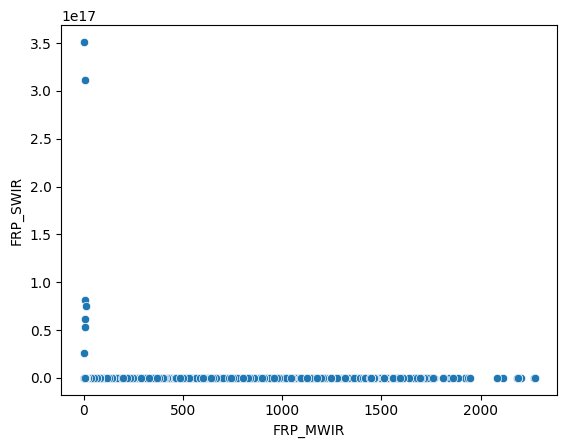

In [38]:
sns.scatterplot(x="FRP_MWIR", y="FRP_SWIR", data=dataset_comb)
plt.show()

In [39]:
temp = dataset_comb.loc[dataset_comb.loc[:,"FRP_SWIR"] != np.inf,:]
temp = temp.loc[~ np.isnan(temp.loc[:,"FRP_SWIR"]),:]
res  = sp.stats.pearsonr(x=temp.loc[:,"FRP_MWIR"], y=temp.loc[:,"FRP_SWIR"])
res

PearsonRResult(statistic=-7.052438890205026e-05, pvalue=0.8770594192983431)

Does the correlation improve if all the zeros (> 90% of the data) are removed in the FRP_SWIR column?

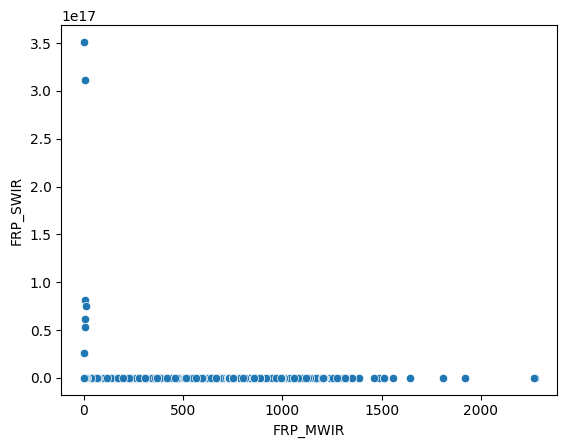

In [40]:
temp = temp.loc[temp.loc[:,"FRP_SWIR"] != 0,:]
sns.scatterplot(x="FRP_MWIR", y="FRP_SWIR", data=temp)
plt.show()

In [41]:
res  = sp.stats.pearsonr(x=temp.loc[:,"FRP_MWIR"], y=temp.loc[:,"FRP_SWIR"])
res

PearsonRResult(statistic=-0.000961510559325435, pvalue=0.5951559291636416)

FRP_MWIR and FRP_SWIR do not correlate

# Look into FRP_MWIR_uncertainty, FRP_SWIR_uncertainty
## Distribution of the uncertainty of mid-wave infrared Fire radiative power (FRP_MWIR_uncertainty)

In [42]:
temp = dataset_comb.loc[:,"FRP_MWIR_uncertainty"]

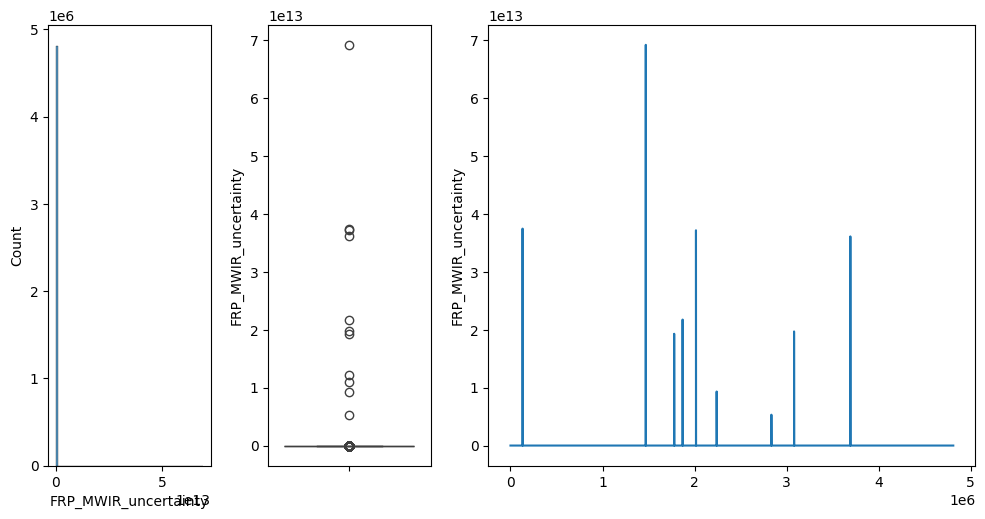

In [43]:
simple_plot(temp)

### Log transfomation of the data

In [44]:
temp = temp.map(math.log)

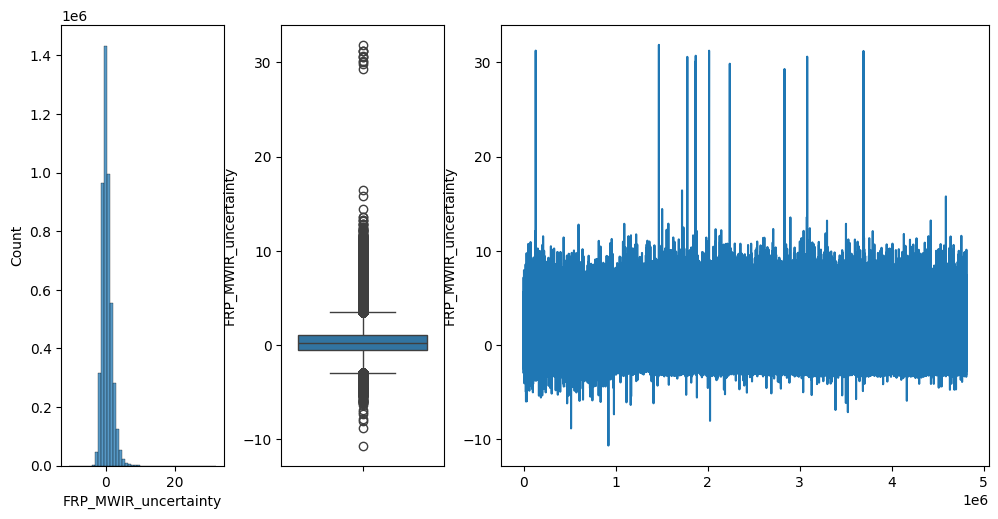

In [45]:
simple_plot(temp)

## Distribution of the uncertainty of short-wave infrared Fire radiative power (FRP_SWIR_uncertainty)

In [46]:
temp = dataset_comb.loc[:,"FRP_SWIR_uncertainty"]

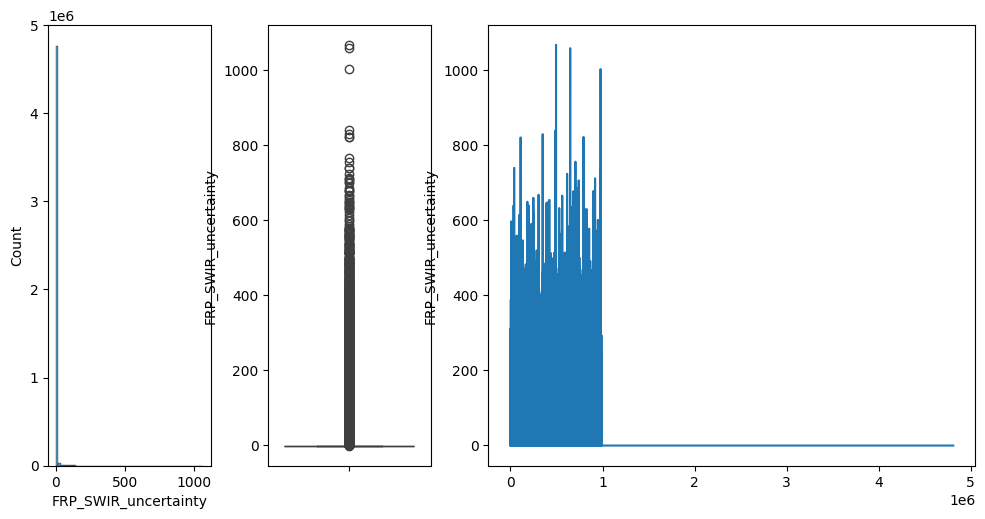

In [47]:
simple_plot(temp)

### Short study of the nature of -1 in the FRP_SWIR_uncertainty

In [48]:
sum(temp == -1)/len(temp)

0.9365104832479811

Do all values that are -1 in FRP_SWIR_uncertainty have 0 in FRP_SWIR? Yes

In [49]:
sum(dataset_comb.loc[dataset_comb.loc[:,"FRP_SWIR_uncertainty"] == -1,"FRP_SWIR"] != 0)

0

Do all values that are 0 in FRP_SWIR have -1 in FRP_SWIR_uncertainty? No

In [50]:
sum(dataset_comb.loc[dataset_comb.loc[:,"FRP_SWIR"] == 0,"FRP_SWIR_uncertainty"] != -1)

49

In [51]:
dataset_comb.loc[(dataset_comb.loc[:,"FRP_SWIR"] == 0) & (dataset_comb.loc[:,"FRP_SWIR_uncertainty"] != -1),:].iloc[-5:,:]

,Column,Row,Date,Time,Latitude,Longitude,sat_zenith,FRP_MWIR,FRP_MWIR_uncertainty,FRP_SWIR,FRP_SWIR_uncertainty,Confidence,F1_flag,Day_flag,Area,Platform,Land/Ocean,Hotspot_class
937211,500,201,20200723,45437,45.13380,-105.77275,35.65422,10.055416,1.056449,0.0,8.529457,0.01,True,False,1996863.125,S3A,True,1
937214,497,200,20200723,45437,45.12564,-105.73817,35.83496,3.354827,1.385213,0.0,5.047648,0.00,True,False,2007170.250,S3A,True,1
941019,1213,397,20200723,122619,-3.93782,142.12047,17.30436,52.130867,5.625305,0.0,6.950148,1.00,True,False,1277892.750,S3B,True,1
949744,464,298,20200724,22745,-24.44478,-57.48542,37.68925,8.389094,1.258840,0.0,11.763828,1.00,True,False,1198360.750,S3A,True,1
949748,463,298,20200724,22745,-24.43803,-57.47825,37.74789,11.612123,1.427807,0.0,7.208269,1.00,True,False,1198360.750,S3A,True,1


Does any values before 2020-07-27 (the day of the last non-Zero FRP_SWIR entry) have -1 in FRP_SWIR_uncertainty? Yes

In [52]:
sum((dataset_comb.loc[:,"Date"] < 20200727) & (dataset_comb.loc[:,"FRP_SWIR_uncertainty"] == -1))

682336

Do all values after 2020-07-27 (the day of the last non-Zero FRP_SWIR entry) have -1 in FRP_SWIR_uncertainty? Yes

In [53]:
sum((dataset_comb.loc[:,"Date"] > 20200727) & (dataset_comb.loc[:,"FRP_SWIR_uncertainty"] != -1))

0

#### Conclusion: The -1 in FRP_SWIR_uncertainty can be used as indicator for missing data in the FRP_SWIR data

In [54]:
temp = temp[temp != -1]

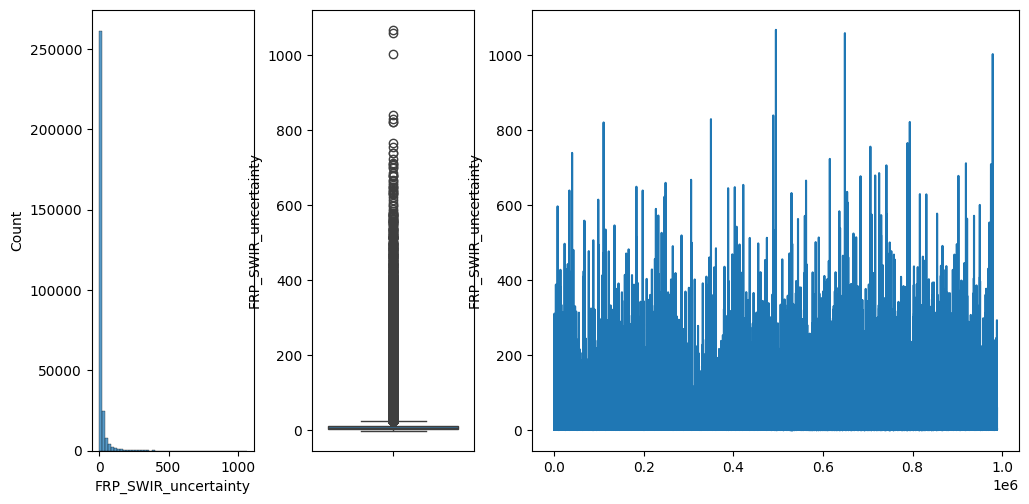

In [55]:
simple_plot(temp)

### Log transfomation of the data

In [56]:
dataset_comb.loc[(dataset_comb.loc[:,"FRP_SWIR_uncertainty"] > -1) & (dataset_comb.loc[:,"FRP_SWIR_uncertainty"] <= 0),:]

,Column,Row,Date,Time,Latitude,Longitude,sat_zenith,FRP_MWIR,FRP_MWIR_uncertainty,FRP_SWIR,FRP_SWIR_uncertainty,Confidence,F1_flag,Day_flag,Area,Platform,Land/Ocean,Hotspot_class
492731,1338,328,20200509,151201,64.48304,75.89336,25.54561,3.571280,0.406336,0.0,-0.016229,1.00,False,False,1485758.375,S3B,True,1
496919,1360,398,20200510,152535,64.92929,71.50889,26.98571,1.165732,0.361828,0.0,-0.101318,1.00,False,False,1548743.375,S3A,True,1
511829,1252,231,20200515,155636,64.06115,67.18221,19.80431,1.089690,0.250415,0.0,-0.428280,1.00,False,False,1328839.125,S3B,True,1
526473,1313,773,20200522,133116,58.43027,107.38577,23.91113,6.062430,1.679044,0.0,-0.197000,0.01,True,False,1445752.000,S3A,True,1
528353,1206,1152,20200522,201605,61.95229,5.38791,16.68143,1.398710,0.402021,0.0,-0.003849,1.00,False,False,1273990.000,S3A,True,1
530457,1324,1021,20200523,140710,60.43833,96.52447,24.63925,1.416618,0.152119,0.0,-0.010695,0.01,True,False,1457145.500,S3B,True,1
531038,1082,204,20200523,162831,64.47237,62.67019,8.84832,1.180419,0.438482,0.0,-0.994362,1.00,False,False,1172015.750,S3A,True,1
533492,1176,719,20200524,134007,58.43915,107.56663,14.73396,6.313677,0.851010,0.0,-0.042950,0.01,True,False,1235964.000,S3B,True,1
842722,1305,114,20200714,103649,62.90993,147.23358,23.36484,3.034609,0.697357,0.0,-0.275799,1.00,False,False,1430281.625,S3A,True,1
842730,1320,115,20200714,103650,62.85947,146.97517,24.36690,1.947018,0.447488,0.0,-0.247082,1.00,False,False,1459465.500,S3A,True,1


some data  point in FRP_SWIR_uncertainty, that are not -1, are less then zero

In [57]:
temp = temp[temp>0]
temp = temp.map(math.log)

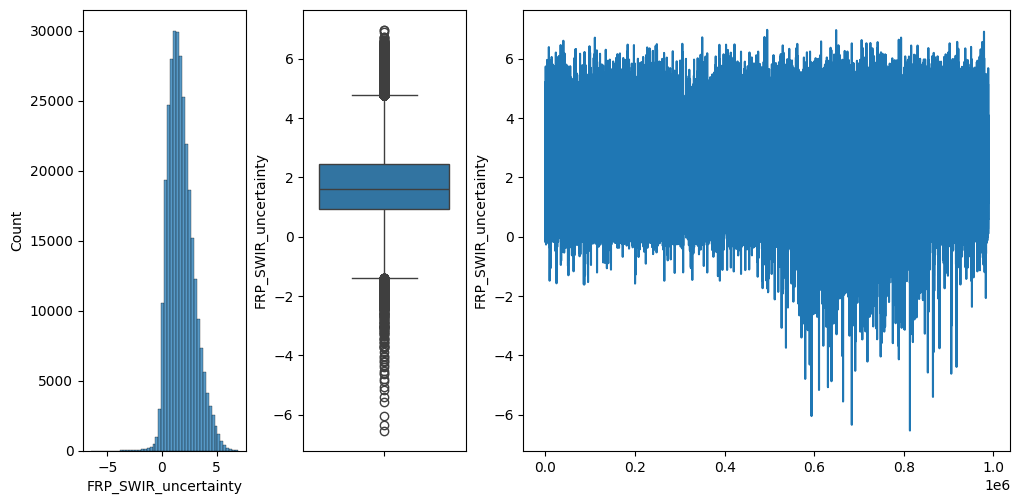

In [58]:
simple_plot(temp)

# Look into Confidence

In [59]:
temp = dataset_comb.loc[:,"Confidence"]

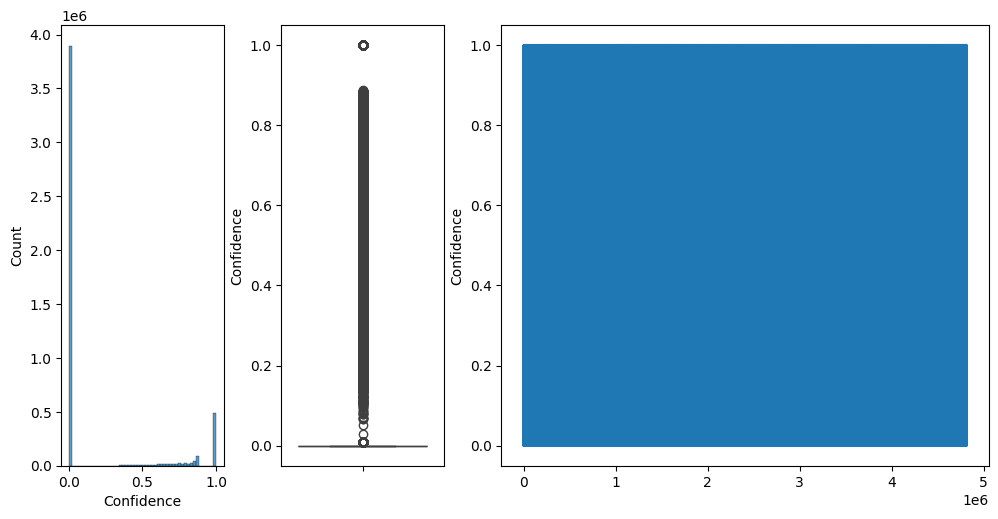

In [60]:
simple_plot(temp)

In [61]:
sum(temp == 0)

3872953

In [62]:
sum(temp == 1)

490680

In [63]:
sum((temp != 1)&(temp != 0))

447996

#### filter out 0 and 1 values

In [64]:
temp = temp[(temp != 1)&(temp != 0)]

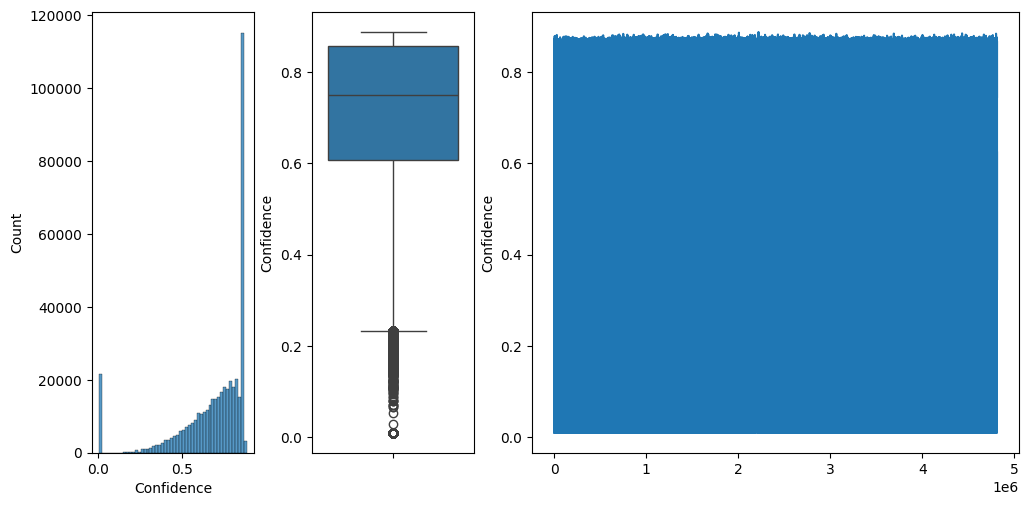

In [65]:
simple_plot(temp)

# Look into Area

In [66]:
temp = dataset_comb.loc[:,"Area"]

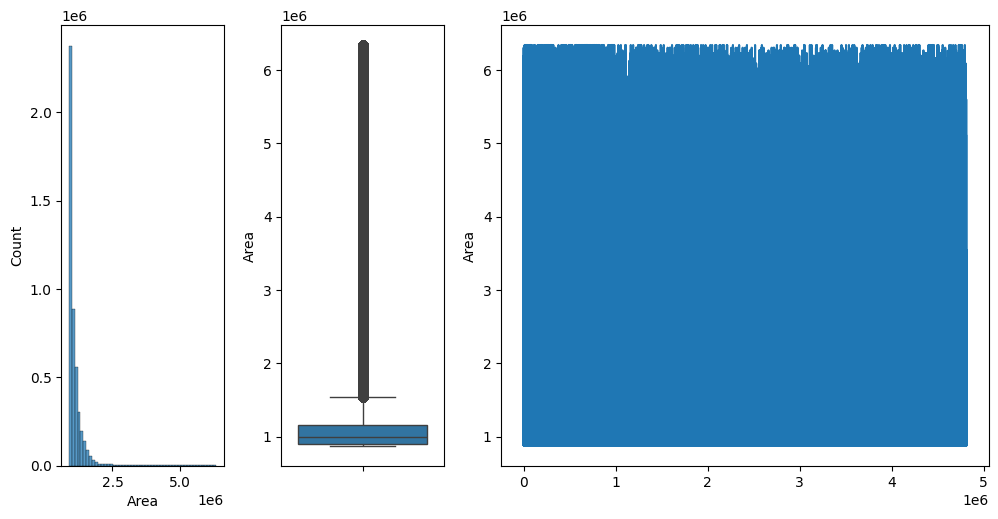

In [67]:
simple_plot(temp)

### Log transfomation of the data

In [68]:
temp = temp.map(math.log)

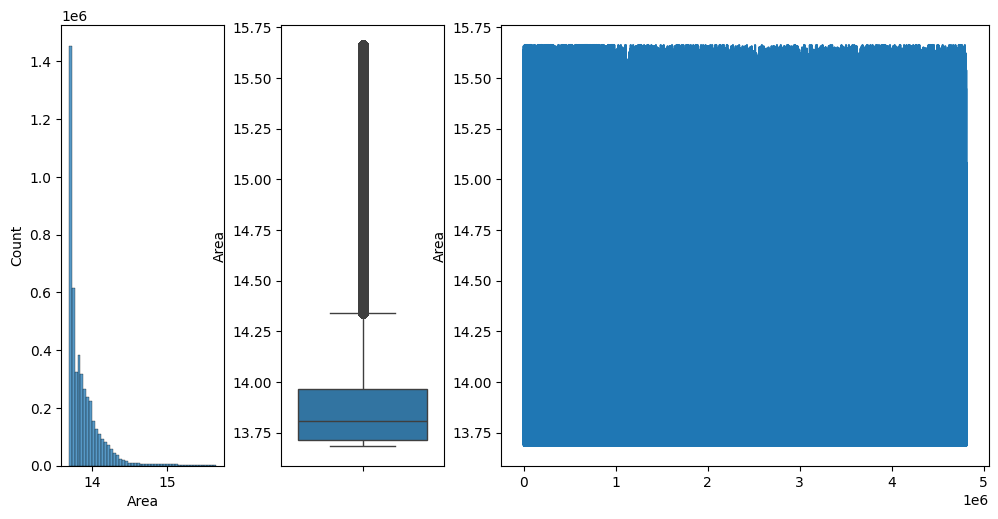

In [69]:
simple_plot(temp)

# Split data into MWIR und SWIR data
## MWIR data

In [70]:
dataset_comb.loc[:5,:]

,Column,Row,Date,Time,Latitude,Longitude,sat_zenith,FRP_MWIR,FRP_MWIR_uncertainty,FRP_SWIR,FRP_SWIR_uncertainty,Confidence,F1_flag,Day_flag,Area,Platform,Land/Ocean,Hotspot_class
0,1102,954,20200301,10813,-20.04511,-44.91568,10.10405,2.908418,0.621121,0.000000,-1.000000,0.0,False,False,1179637.125,S3B,True,1
1,459,1071,20200301,10854,-17.65403,-39.24297,38.03109,4.561074,0.715353,0.000000,-1.000000,0.0,False,False,2207239.750,S3B,True,1
2,512,31,20200301,10914,-16.36876,-40.09173,34.87470,6.209808,2.571126,0.000000,-1.000000,0.0,False,False,1976518.125,S3B,True,1
3,511,29,20200301,10914,-16.37848,-40.08594,34.93529,5.360111,2.006838,35.406391,8.067273,1.0,False,False,1976518.125,S3B,True,1
4,510,31,20200301,10914,-16.36404,-40.07747,34.99621,5.476526,0.996112,18.785072,4.249864,1.0,False,False,1981577.625,S3B,True,1
5,437,581,20200301,11043,-11.36490,-40.65165,39.37939,11.264795,1.174866,33.363258,7.462563,1.0,False,False,2326350.500,S3B,True,1


The Day_flag only contains `False` values and the Land/Ocean only contain `True` values

In [71]:
dataset_MWIR  = dataset_comb.loc[:, ~dataset_comb.columns.isin(['sat_zenith', 'FRP_SWIR', 'FRP_SWIR_uncertainty', 'Day_flag', 'Land/Ocean'])]
dataset_MWIR.loc[:5,:]

,Column,Row,Date,Time,Latitude,Longitude,FRP_MWIR,FRP_MWIR_uncertainty,Confidence,F1_flag,Area,Platform,Hotspot_class
0,1102,954,20200301,10813,-20.04511,-44.91568,2.908418,0.621121,0.0,False,1179637.125,S3B,1
1,459,1071,20200301,10854,-17.65403,-39.24297,4.561074,0.715353,0.0,False,2207239.750,S3B,1
2,512,31,20200301,10914,-16.36876,-40.09173,6.209808,2.571126,0.0,False,1976518.125,S3B,1
3,511,29,20200301,10914,-16.37848,-40.08594,5.360111,2.006838,1.0,False,1976518.125,S3B,1
4,510,31,20200301,10914,-16.36404,-40.07747,5.476526,0.996112,1.0,False,1981577.625,S3B,1
5,437,581,20200301,11043,-11.36490,-40.65165,11.264795,1.174866,1.0,False,2326350.500,S3B,1


In [72]:
dataset_MWIR.insert(7, 'log_FRP_MWIR', dataset_MWIR.loc[:,'FRP_MWIR'].map(math.log))
dataset_MWIR.loc[:5,:]

,Column,Row,Date,Time,Latitude,Longitude,FRP_MWIR,log_FRP_MWIR,FRP_MWIR_uncertainty,Confidence,F1_flag,Area,Platform,Hotspot_class
0,1102,954,20200301,10813,-20.04511,-44.91568,2.908418,1.067609,0.621121,0.0,False,1179637.125,S3B,1
1,459,1071,20200301,10854,-17.65403,-39.24297,4.561074,1.517558,0.715353,0.0,False,2207239.750,S3B,1
2,512,31,20200301,10914,-16.36876,-40.09173,6.209808,1.826130,2.571126,0.0,False,1976518.125,S3B,1
3,511,29,20200301,10914,-16.37848,-40.08594,5.360111,1.678985,2.006838,1.0,False,1976518.125,S3B,1
4,510,31,20200301,10914,-16.36404,-40.07747,5.476526,1.700471,0.996112,1.0,False,1981577.625,S3B,1
5,437,581,20200301,11043,-11.36490,-40.65165,11.264795,2.421682,1.174866,1.0,False,2326350.500,S3B,1


### Are the FireRP distribution different for the different categorical variables?

In [73]:
print(dataset_MWIR.loc[:,"F1_flag"].value_counts())
print()
print(dataset_MWIR.loc[:,"Platform"].value_counts())
print()
print(dataset_MWIR.loc[:,"Hotspot_class"].value_counts())

F1_flag
True     4144742
False     666887
Name: count, dtype: int64

Platform
S3B    2510521
S3A    2301108
Name: count, dtype: int64

Hotspot_class
1    4771676
2      26953
8      13000
Name: count, dtype: int64


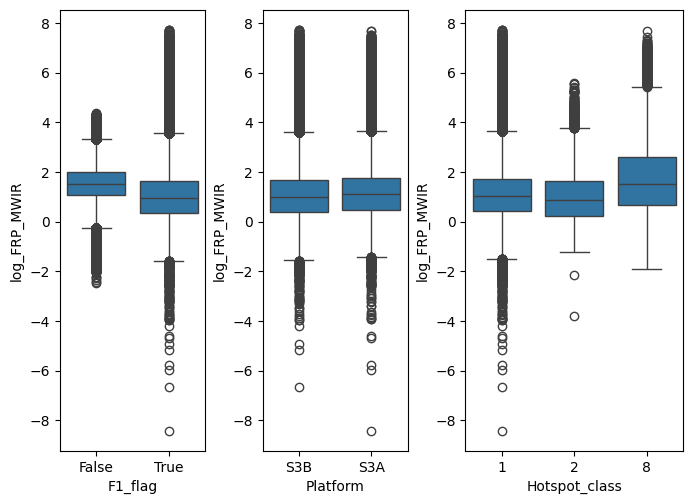

In [74]:
fig, axs = plt.subplots(ncols=3, figsize=(7,5), gridspec_kw={'width_ratios': [2, 2, 3]})
fig.tight_layout()
sns.boxplot(x="F1_flag", y="log_FRP_MWIR", data=dataset_MWIR, ax=axs[0])
sns.boxplot(x="Platform", y="log_FRP_MWIR", data=dataset_MWIR, ax=axs[1])
sns.boxplot(x="Hotspot_class", y="log_FRP_MWIR", data=dataset_MWIR, ax=axs[2])
plt.show()

The “F1_flag” indicates the FRP for the Active fire is from F1 channel with 1 and 0 means the FRP is from S7.
MIR channel measurements in excess of 311 K can only be provided by F1, whereas cooler BTs are more precisely measured by the lower-noise S7 channel. 
The instantaneous field of view (IFOV) of the SLSTR S7 and F1 channels are very different due to their differing detector shapes and matching IFOV.
A key consideration for the SLSTR AF application is that data from both S7 and F1 must be combined for any production algorithm to be most effective.

The two satelites Sentinel-3A and Sentinel -3B provided similar results

## SWIR data

In [75]:
dataset_comb.loc[:5,:]

,Column,Row,Date,Time,Latitude,Longitude,sat_zenith,FRP_MWIR,FRP_MWIR_uncertainty,FRP_SWIR,FRP_SWIR_uncertainty,Confidence,F1_flag,Day_flag,Area,Platform,Land/Ocean,Hotspot_class
0,1102,954,20200301,10813,-20.04511,-44.91568,10.10405,2.908418,0.621121,0.000000,-1.000000,0.0,False,False,1179637.125,S3B,True,1
1,459,1071,20200301,10854,-17.65403,-39.24297,38.03109,4.561074,0.715353,0.000000,-1.000000,0.0,False,False,2207239.750,S3B,True,1
2,512,31,20200301,10914,-16.36876,-40.09173,34.87470,6.209808,2.571126,0.000000,-1.000000,0.0,False,False,1976518.125,S3B,True,1
3,511,29,20200301,10914,-16.37848,-40.08594,34.93529,5.360111,2.006838,35.406391,8.067273,1.0,False,False,1976518.125,S3B,True,1
4,510,31,20200301,10914,-16.36404,-40.07747,34.99621,5.476526,0.996112,18.785072,4.249864,1.0,False,False,1981577.625,S3B,True,1
5,437,581,20200301,11043,-11.36490,-40.65165,39.37939,11.264795,1.174866,33.363258,7.462563,1.0,False,False,2326350.500,S3B,True,1


The F1_Flag is only associated to the MWIR data

In [76]:
dataset_SWIR  = dataset_comb.loc[
    dataset_comb.loc[:,'FRP_SWIR_uncertainty'] != -1, 
    ~dataset_comb.columns.isin(['sat_zenith', 'FRP_MWIR', 'FRP_MWIR_uncertainty', 'Day_flag', 'Land/Ocean', 'F1_flag'])].reset_index()
dataset_SWIR.loc[:5,:]

,index,Column,Row,Date,Time,Latitude,Longitude,FRP_SWIR,FRP_SWIR_uncertainty,Confidence,Area,Platform,Hotspot_class
0,3,511,29,20200301,10914,-16.37848,-40.08594,35.406391,8.067273,1.0,1976518.125,S3B,1
1,4,510,31,20200301,10914,-16.36404,-40.07747,18.785072,4.249864,1.0,1981577.625,S3B,1
2,5,437,581,20200301,11043,-11.36490,-40.65165,33.363258,7.462563,1.0,2326350.500,S3B,1
3,8,391,800,20200301,11120,-9.33486,-40.71750,29.765263,5.976156,1.0,2587528.250,S3B,1
4,10,1430,735,20200301,11555,5.66203,-53.71773,7.795226,1.459992,1.0,1741396.125,S3B,1
5,11,1080,967,20200301,14446,-30.45759,-51.92012,3.019115,2.348011,1.0,1171125.125,S3A,1


In [77]:
dataset_SWIR.shape

(305488, 13)

### Data cleaning

In [78]:
print("Number of zero values in FRP_SWIR:", sum(dataset_SWIR.loc[:, 'FRP_SWIR'] == 0))

Number of zero values in FRP_SWIR: 49


In [79]:
print("Number of infinite values in FRP_SWIR:", sum(dataset_SWIR.loc[:, 'FRP_SWIR'] == math.inf))

Number of infinite values in FRP_SWIR: 6


We will remove the zero values and set the inf values to the max value of the FRP_SWIR

In [80]:
dataset_SWIR = dataset_SWIR.loc[dataset_SWIR.loc[:, 'FRP_SWIR'] != 0, :]

In [81]:
max_SWIR = dataset_SWIR.loc[dataset_SWIR.loc[:, 'FRP_SWIR'] != math.inf, 'FRP_SWIR'].max()
dataset_SWIR.loc[dataset_SWIR.loc[:, 'FRP_SWIR'] == math.inf, 'FRP_SWIR'] = max_SWIR

In [82]:
dataset_SWIR.loc[:,'log_FRP_SWIR'] = dataset_SWIR.loc[:,'FRP_SWIR'].map(math.log)
dataset_SWIR.loc[:5]

,index,Column,Row,Date,Time,Latitude,Longitude,FRP_SWIR,FRP_SWIR_uncertainty,Confidence,Area,Platform,Hotspot_class,log_FRP_SWIR
0,3,511,29,20200301,10914,-16.37848,-40.08594,35.406391,8.067273,1.0,1976518.125,S3B,1,3.566892
1,4,510,31,20200301,10914,-16.36404,-40.07747,18.785072,4.249864,1.0,1981577.625,S3B,1,2.933063
2,5,437,581,20200301,11043,-11.36490,-40.65165,33.363258,7.462563,1.0,2326350.500,S3B,1,3.507455
3,8,391,800,20200301,11120,-9.33486,-40.71750,29.765263,5.976156,1.0,2587528.250,S3B,1,3.393342
4,10,1430,735,20200301,11555,5.66203,-53.71773,7.795226,1.459992,1.0,1741396.125,S3B,1,2.053511
5,11,1080,967,20200301,14446,-30.45759,-51.92012,3.019115,2.348011,1.0,1171125.125,S3A,1,1.104964


### Are the FireRP distribution different for the different categorical variables?

In [83]:
print(dataset_SWIR.loc[:,"Platform"].value_counts())
print()
print(dataset_SWIR.loc[:,"Hotspot_class"].value_counts())

Platform
S3B    158795
S3A    146644
Name: count, dtype: int64

Hotspot_class
1    302349
2      2155
8       935
Name: count, dtype: int64


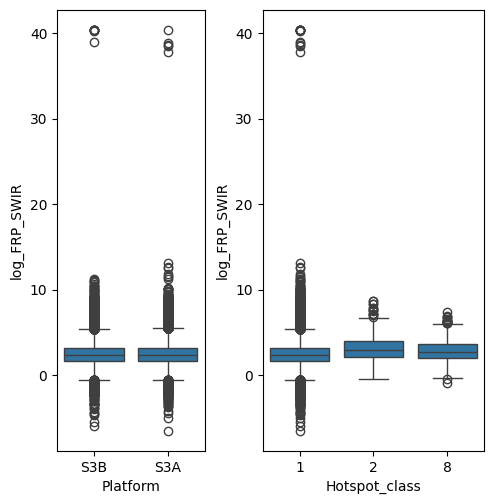

In [84]:
fig, axs = plt.subplots(ncols=2, figsize=(5,5), gridspec_kw={'width_ratios': [2, 3]})
fig.tight_layout()
sns.boxplot(x="Platform", y="log_FRP_SWIR", data=dataset_SWIR, ax=axs[0])
sns.boxplot(x="Hotspot_class", y="log_FRP_SWIR", data=dataset_SWIR, ax=axs[1])
plt.show()

#### Without the outliers

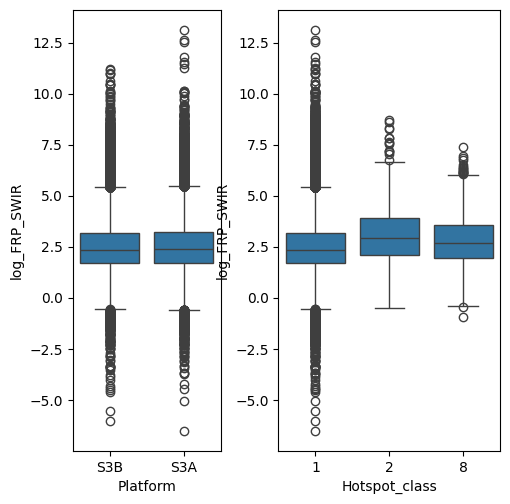

In [85]:
fig, axs = plt.subplots(ncols=2, figsize=(5,5), gridspec_kw={'width_ratios': [2, 3]})
fig.tight_layout()
sns.boxplot(x="Platform", y="log_FRP_SWIR", data=dataset_SWIR.loc[dataset_SWIR.loc[:,"log_FRP_SWIR"]<20,:], ax=axs[0])
sns.boxplot(x="Hotspot_class", y="log_FRP_SWIR", data=dataset_SWIR.loc[dataset_SWIR.loc[:,"log_FRP_SWIR"]<20,:], ax=axs[1])
plt.show()

# Aggregation of the FRP_MWIR dataframe into a datacube FRP_MWIR(Date, Lat_bin, Lon_bin)

## Binning of Latitude and Longitude

In [86]:
dataset_MWIR.insert(6, 'Lat_bin', pd.cut(dataset_MWIR.loc[:,'Latitude'], range(-90,91)))
dataset_MWIR.insert(7, 'Lon_bin', pd.cut(dataset_MWIR.loc[:,'Longitude'], range(-180,181)))

dataset_MWIR.loc[:5,:]

,Column,Row,Date,Time,Latitude,Longitude,Lat_bin,Lon_bin,FRP_MWIR,log_FRP_MWIR,FRP_MWIR_uncertainty,Confidence,F1_flag,Area,Platform,Hotspot_class
0,1102,954,20200301,10813,-20.04511,-44.91568,"(-21, -20]","(-45, -44]",2.908418,1.067609,0.621121,0.0,False,1179637.125,S3B,1
1,459,1071,20200301,10854,-17.65403,-39.24297,"(-18, -17]","(-40, -39]",4.561074,1.517558,0.715353,0.0,False,2207239.750,S3B,1
2,512,31,20200301,10914,-16.36876,-40.09173,"(-17, -16]","(-41, -40]",6.209808,1.826130,2.571126,0.0,False,1976518.125,S3B,1
3,511,29,20200301,10914,-16.37848,-40.08594,"(-17, -16]","(-41, -40]",5.360111,1.678985,2.006838,1.0,False,1976518.125,S3B,1
4,510,31,20200301,10914,-16.36404,-40.07747,"(-17, -16]","(-41, -40]",5.476526,1.700471,0.996112,1.0,False,1981577.625,S3B,1
5,437,581,20200301,11043,-11.36490,-40.65165,"(-12, -11]","(-41, -40]",11.264795,2.421682,1.174866,1.0,False,2326350.500,S3B,1


## Separate date into Year, Month, Day

In [87]:
dataset_MWIR.insert(4, 'Year', dataset_MWIR.loc[:,'Date'].map(lambda x: int(str(x)[:4])))
dataset_MWIR.insert(5, 'Month', dataset_MWIR.loc[:,'Date'].map(lambda x: int(str(x)[4:6])))
dataset_MWIR.insert(6, 'Day', dataset_MWIR.loc[:,'Date'].map(lambda x: int(str(x)[6:8])))
dataset_MWIR.loc[:5,:]

,Column,Row,Date,Time,Year,Month,Day,Latitude,Longitude,Lat_bin,Lon_bin,FRP_MWIR,log_FRP_MWIR,FRP_MWIR_uncertainty,Confidence,F1_flag,Area,Platform,Hotspot_class
0,1102,954,20200301,10813,2020,3,1,-20.04511,-44.91568,"(-21, -20]","(-45, -44]",2.908418,1.067609,0.621121,0.0,False,1179637.125,S3B,1
1,459,1071,20200301,10854,2020,3,1,-17.65403,-39.24297,"(-18, -17]","(-40, -39]",4.561074,1.517558,0.715353,0.0,False,2207239.750,S3B,1
2,512,31,20200301,10914,2020,3,1,-16.36876,-40.09173,"(-17, -16]","(-41, -40]",6.209808,1.826130,2.571126,0.0,False,1976518.125,S3B,1
3,511,29,20200301,10914,2020,3,1,-16.37848,-40.08594,"(-17, -16]","(-41, -40]",5.360111,1.678985,2.006838,1.0,False,1976518.125,S3B,1
4,510,31,20200301,10914,2020,3,1,-16.36404,-40.07747,"(-17, -16]","(-41, -40]",5.476526,1.700471,0.996112,1.0,False,1981577.625,S3B,1
5,437,581,20200301,11043,2020,3,1,-11.36490,-40.65165,"(-12, -11]","(-41, -40]",11.264795,2.421682,1.174866,1.0,False,2326350.500,S3B,1


## Aggregation

In [88]:
temp = dataset_MWIR.groupby(["Date", "Lat_bin", "Lon_bin"], observed =False, sort = True)["FRP_MWIR"].sum().reset_index()
temp[:5]

,Date,Lat_bin,Lon_bin,FRP_MWIR
0,20200301,"(-90, -89]","(-180, -179]",0.0
1,20200301,"(-90, -89]","(-179, -178]",0.0
2,20200301,"(-90, -89]","(-178, -177]",0.0
3,20200301,"(-90, -89]","(-177, -176]",0.0
4,20200301,"(-90, -89]","(-176, -175]",0.0


## Reshaping into a cube

In [89]:
temp = temp.pivot(index=["Lat_bin", "Lon_bin"], columns="Date", values="FRP_MWIR")

## Change data from pandas dataframe to numpy array

Reshape (180, 360) to (1, 180, 360) to enable concatenation the time across the axis 0

In [90]:
np.array(temp.iloc[:,0].unstack()).reshape((1,180, 360))

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [91]:
datacube_MWIR = None
for i in range(temp.shape[1]):
    if datacube_MWIR is not None:
        datacube_MWIR = np.concatenate((datacube_MWIR, np.array(temp.iloc[:,i].unstack()).reshape((1,180, 360))), axis=0)
    else:
        datacube_MWIR = np.array(temp.iloc[:,i].unstack()).reshape((1,180, 360))

datacube_MWIR.shape

(365, 180, 360)

# Plotting
## Color shemes

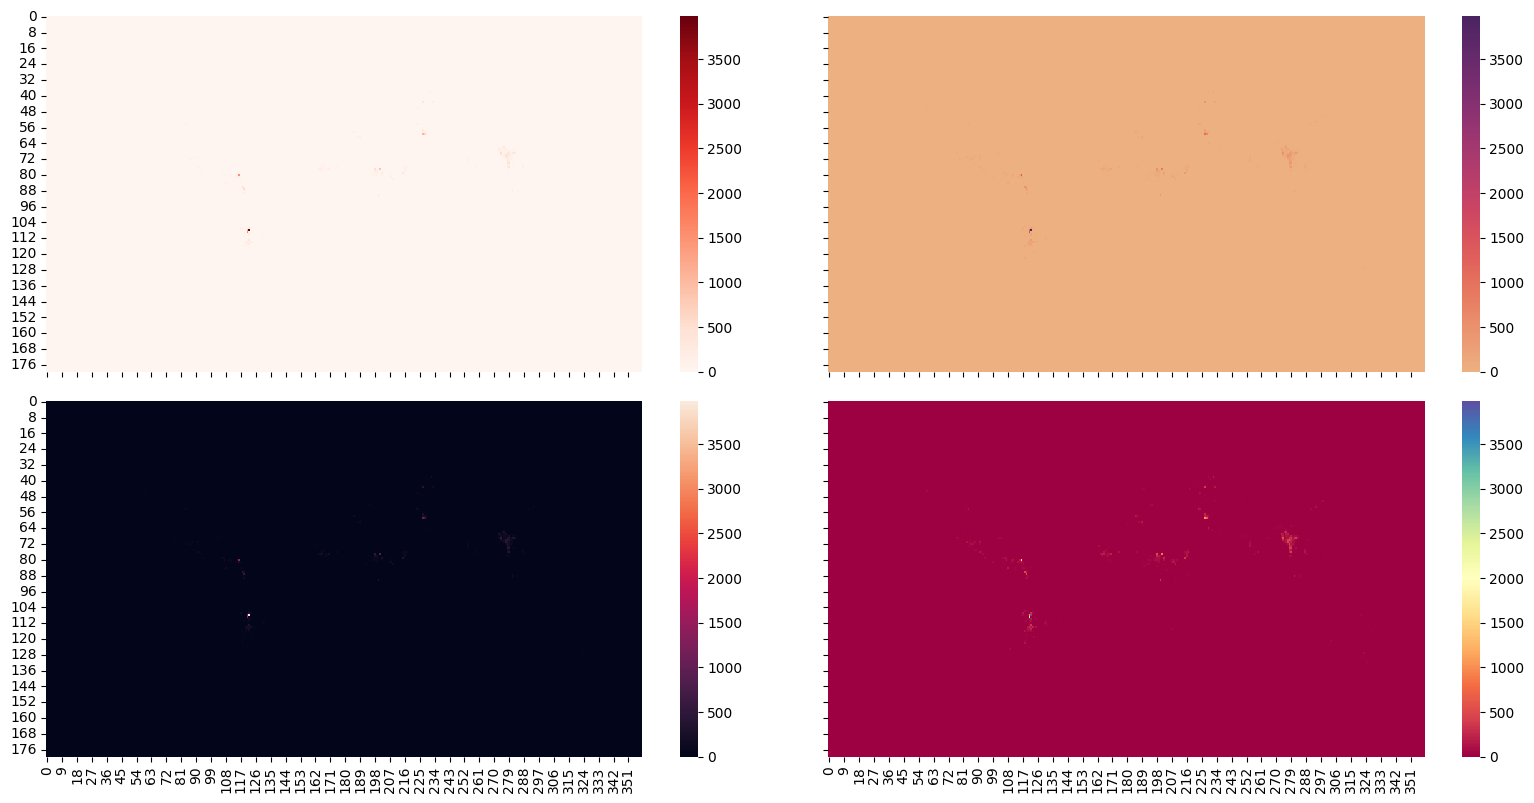

In [92]:
temp_idx = 10
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(16,8))
fig.tight_layout()
sns.heatmap(datacube_MWIR[temp_idx,::-1,:], cmap="Reds", ax=axs[0,0])
sns.heatmap(datacube_MWIR[temp_idx,::-1,:], cmap="flare", ax=axs[0,1])
sns.heatmap(datacube_MWIR[temp_idx,::-1,:], ax=axs[1,0])
sns.heatmap(datacube_MWIR[temp_idx,::-1,:], cmap="Spectral", ax=axs[1,1])
plt.show()

## Aggregation over time

In [93]:
temp = datacube_MWIR.sum(axis = 0)

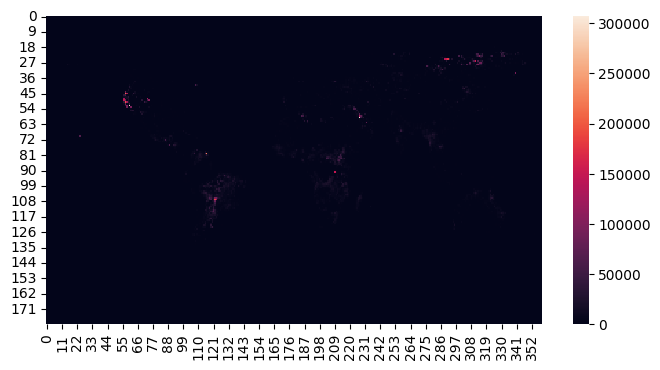

In [94]:
plt.figure(figsize=(8,4))
sns.heatmap(temp[::-1,:])
plt.show()

## Log transformation

In [95]:
min(temp[temp != 0])

0.177206

In [96]:
temp = np.vectorize(lambda x: math.log(x) if x>0 else math.log(0.01))(temp)

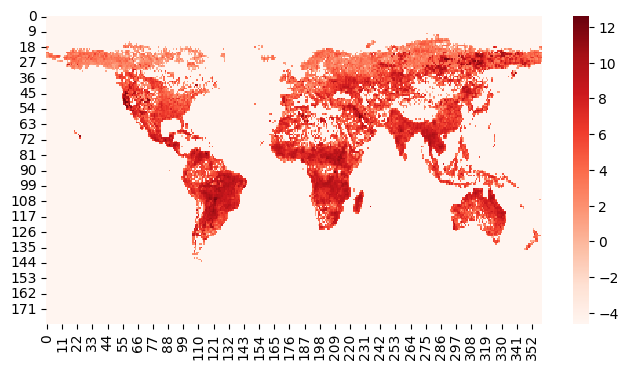

In [97]:
plt.figure(figsize=(8,4))
sns.heatmap(temp[::-1,:], cmap="Reds")
plt.show()

# Log transform of the whole data cube

In [98]:
min(datacube_MWIR[datacube_MWIR != 0])

0.019093

In [99]:
log_datacube_MWIR = np.vectorize(lambda x: math.log(x) if x>0 else math.log(0.01))(datacube_MWIR)

### view of a single time slice

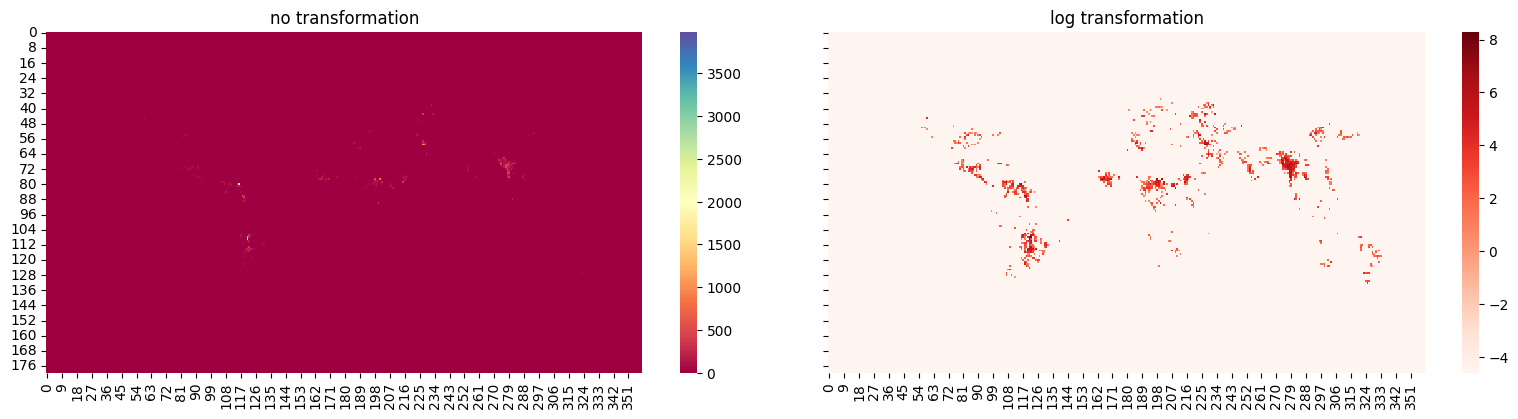

In [100]:
temp_idx = 10
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(16,4))
fig.tight_layout()
sns.heatmap(datacube_MWIR[temp_idx,::-1,:], cmap="Spectral", ax=axs[0])
sns.heatmap(log_datacube_MWIR[temp_idx,::-1,:], cmap="Reds", ax=axs[1])
axs[0].set_title('no transformation')
axs[1].set_title('log transformation')
plt.show()

# Aggregation of the FRP_SWIR dataframe into a datacube FRP_SWIR(Date, Lat_bin, Lon_bin)

Exact same procedure as with the FRP_MWIR data

In [101]:
## Binning
dataset_SWIR.loc[:,'Lat_bin'] = pd.cut(dataset_SWIR.loc[:,'Latitude'], range(-90,91))
dataset_SWIR.loc[:,'Lon_bin'] = pd.cut(dataset_SWIR.loc[:,'Longitude'], range(-180,181))
## Sep Date
dataset_SWIR.loc[:,'Year'] = dataset_SWIR.loc[:,'Date'].map(lambda x: int(str(x)[:4]))
dataset_SWIR.loc[:,'Month'] = dataset_SWIR.loc[:,'Date'].map(lambda x: int(str(x)[4:6]))
dataset_SWIR.loc[:,'Day'] = dataset_SWIR.loc[:,'Date'].map(lambda x: int(str(x)[6:8]))
## Aggregation
temp = dataset_SWIR.groupby(["Date", "Lat_bin", "Lon_bin"], observed =False, sort = True)["FRP_SWIR"].sum().reset_index()
## Pivot
temp = temp.pivot(index=["Lat_bin", "Lon_bin"], columns="Date", values="FRP_SWIR")
## Change to Numpy.array
datacube_SWIR = None
for i in range(temp.shape[1]):
    if datacube_SWIR is not None:
        datacube_SWIR = np.concatenate((datacube_SWIR, np.array(temp.iloc[:,i].unstack()).reshape((1,180, 360))), axis=0)
    else:
        datacube_SWIR = np.array(temp.iloc[:,i].unstack()).reshape((1,180, 360))


Log transformation

In [102]:
min(datacube_SWIR[datacube_SWIR != 0])

0.001504

In [103]:
log_datacube_SWIR = np.vectorize(lambda x: math.log(x) if x>0 else math.log(0.001))(datacube_SWIR)

Aggregation over time

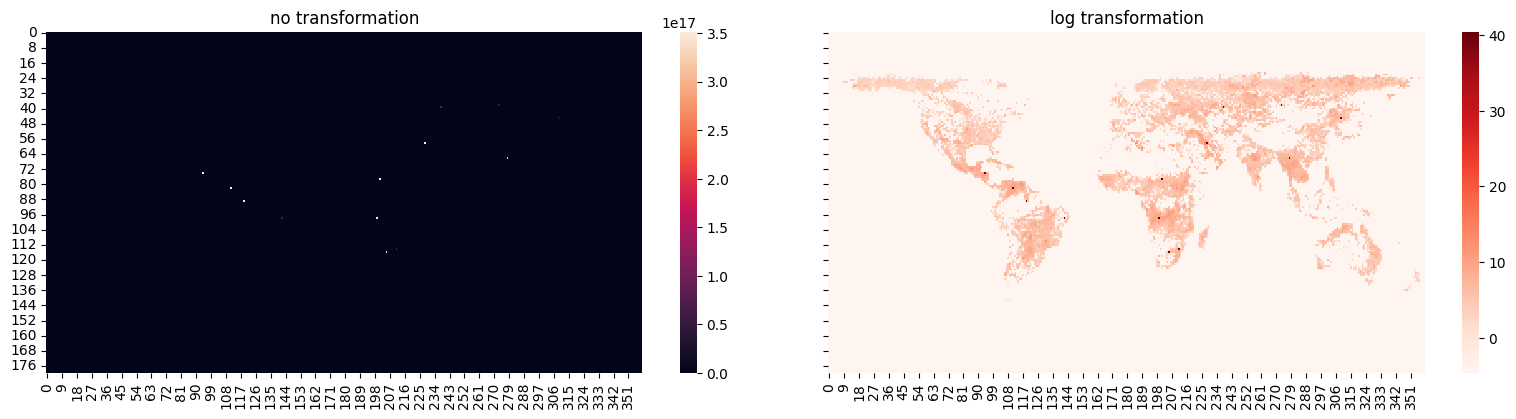

In [104]:
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(16,4))
fig.tight_layout()
temp = datacube_SWIR.sum(axis = 0)
sns.heatmap(temp[::-1,:], ax=axs[0])
min(temp[temp != 0])
temp = np.vectorize(lambda x: math.log(x) if x>0 else math.log(0.01))(temp)
sns.heatmap(temp[::-1,:], cmap="Reds", ax=axs[1])
axs[0].set_title('no transformation')
axs[1].set_title('log transformation')
plt.show()

remove outliers

In [109]:
temp = datacube_SWIR.copy()
temp[temp > 1e13] = 0
temp = temp.sum(axis = 0)
min(temp[temp != 0])

0.154376

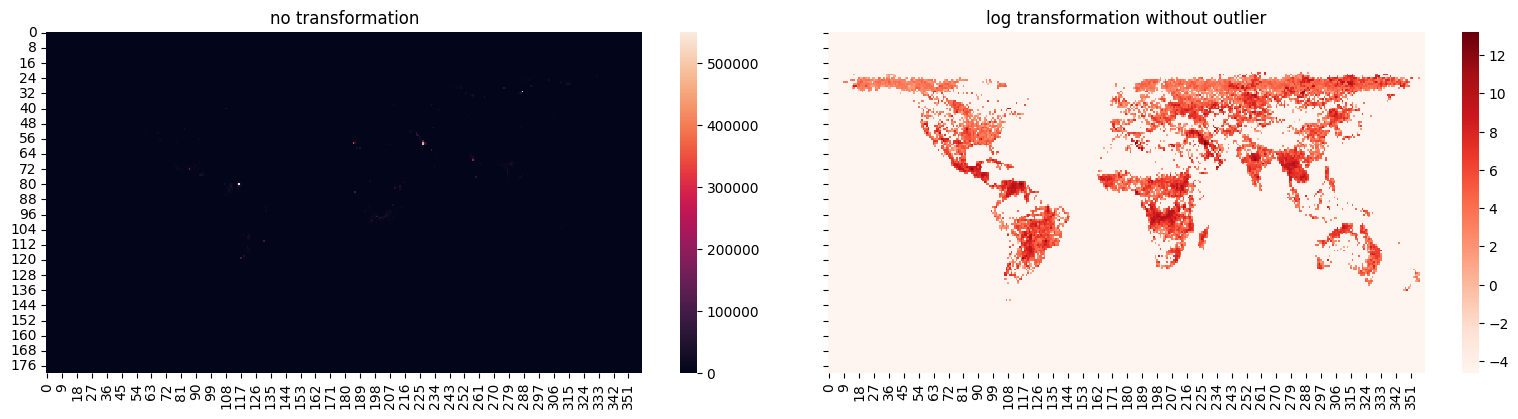

In [110]:
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(16,4))
fig.tight_layout()
sns.heatmap(temp[::-1,:], ax=axs[0])
temp = np.vectorize(lambda x: math.log(x) if x>0 else math.log(0.01))(temp)
sns.heatmap(temp[::-1,:], cmap="Reds", ax=axs[1])
axs[0].set_title('no transformation')
axs[1].set_title('log transformation without outlier')
plt.show()

# Comparison between the FRP_MWIR and FRP_SWIR data

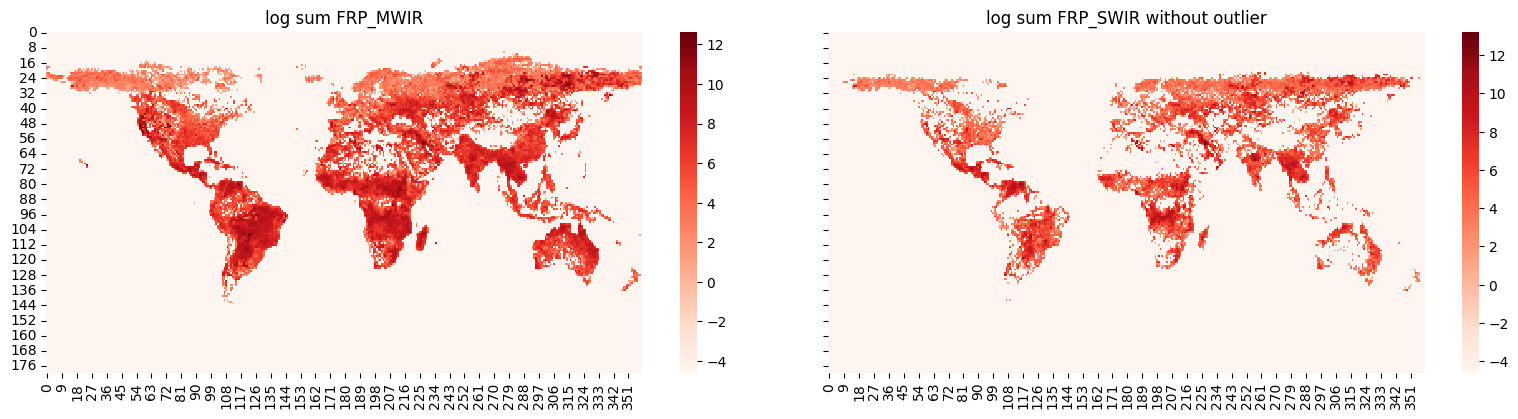

In [107]:
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(16,4))
fig.tight_layout()
sns.heatmap(temp[::-1,:], cmap="Reds", ax=axs[1])
temp = datacube_MWIR.sum(axis = 0)
temp = np.vectorize(lambda x: math.log(x) if x>0 else math.log(0.01))(temp)
sns.heatmap(temp[::-1,:], cmap="Reds", ax=axs[0])
axs[0].set_title('log sum FRP_MWIR')
axs[1].set_title('log sum FRP_SWIR without outlier')
plt.show()

# Saving

In [143]:
dataset_comb.to_csv("./data/FireRP_dataset_comb.csv")
dataset_MWIR.to_csv("./data/FireRP_dataset_MWIR.csv")
dataset_SWIR.to_csv("./data/FireRP_dataset_SWIR.csv")

In [14]:
np.save("./data/FireRP_time.npy", dataset_comb.loc[:,"Date"].unique())

In [411]:
np.save("./data/FireRP_datacube_MWIR.npy", datacube_MWIR)
np.save("./data/FireRP_log_datacube_MWIR.npy", log_datacube_MWIR)
np.save("./data/FireRP_datacube_SWIR.npy", datacube_SWIR)
np.save("./data/FireRP_log_datacube_SWIR.npy", log_datacube_SWIR)